# A tabular Q-learning approach to price impact

In [1]:
import numba
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import binom
from numba import njit, prange

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [3]:
sns.set_palette("colorblind")

## Problem setup

We consider an array of signals $S[\cdot]$ and a 2-dimensional array of prices $P[\cdot, \cdot]$.
Let $Q_t \in \{a_\text{min}, \ldots, a_\text{max}\}$ be the inventory at time $t$.

The return at time $T$ is given by
$$
    G_T = X_T + Q_t\,S_t-\alpha\,Q_T^2,
$$
with $X_T = X_{T-1} - a_{T-1}\,(P_{T-1} + \kappa\,a_{t-1})$, $Q_T = Q_{T-1} + a_T$,
$\alpha$ the inventory, $\kappa$ the temporary price impact (or transaction cost) parameter.

We define the signal and price at time $T$ as the elements in the array
$$
\begin{aligned}
S_T &:= S[is_{T}]\\
P_T &:= P[ip_T, is_T]
\end{aligned}
$$

# We model returns

In [4]:
changes_prices = np.linspace(-5, 5, 20)
changes_signal = np.linspace(-3, 3, 10)

In [70]:
@njit
def set_seed(seed):
    np.random.seed(seed)

@njit
def sigmoid(z): return 1 / (1 + np.exp(-z))


@njit
def clip(a, a_min, a_max):
    return np.minimum(a_max, np.maximum(a, a_min))


@njit
def step_signal(signal_prev, force_signal, reversion_factor, p, stride, signal_mid):
    k = np.random.binomial(2 * force_signal, p)
    k = (k - force_signal) * stride
    signal = signal_prev + reversion_factor * (signal_mid - signal_prev) + k
    return signal

@njit
def step_price(price_prev, signal, force_price, price_impact, action, stride):
    j = np.random.binomial(2 * force_price, sigmoid(action * price_impact))
    j = (j - force_price) * stride
    price = price_prev + signal + j
    return price

In [71]:
force_signal = 5
force_price = 5
reversion_factor = 0.1
p = 0.5
stride = 0.1
signal_mid = 0

signal = 0.0
price = 10.0

prices = []
signals = []
for i in range(100):
    signal = step_signal(signal, force_signal, reversion_factor, p, stride, signal_mid)
    price = step_price(price,  signal, force_price, price_impact, 0, stride)
    prices.append(price)
    signals.append(signal)

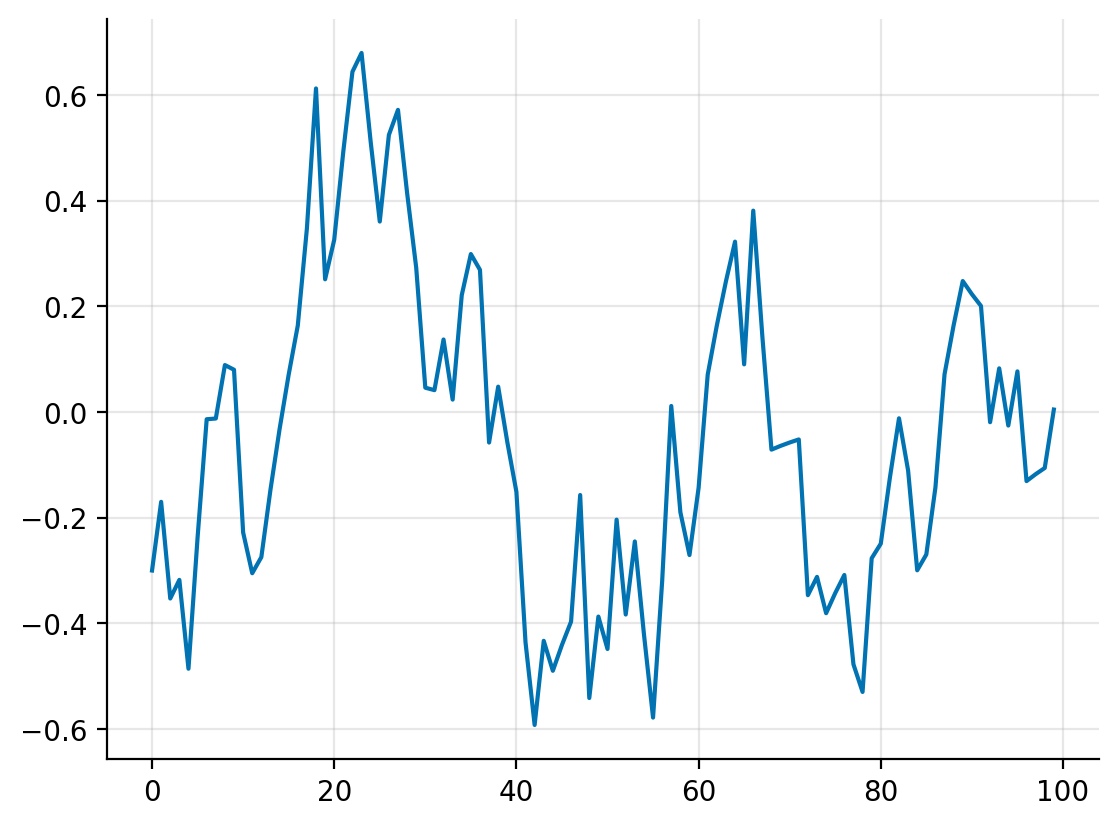

In [72]:
plt.plot(signals)
plt.grid(alpha=0.3)

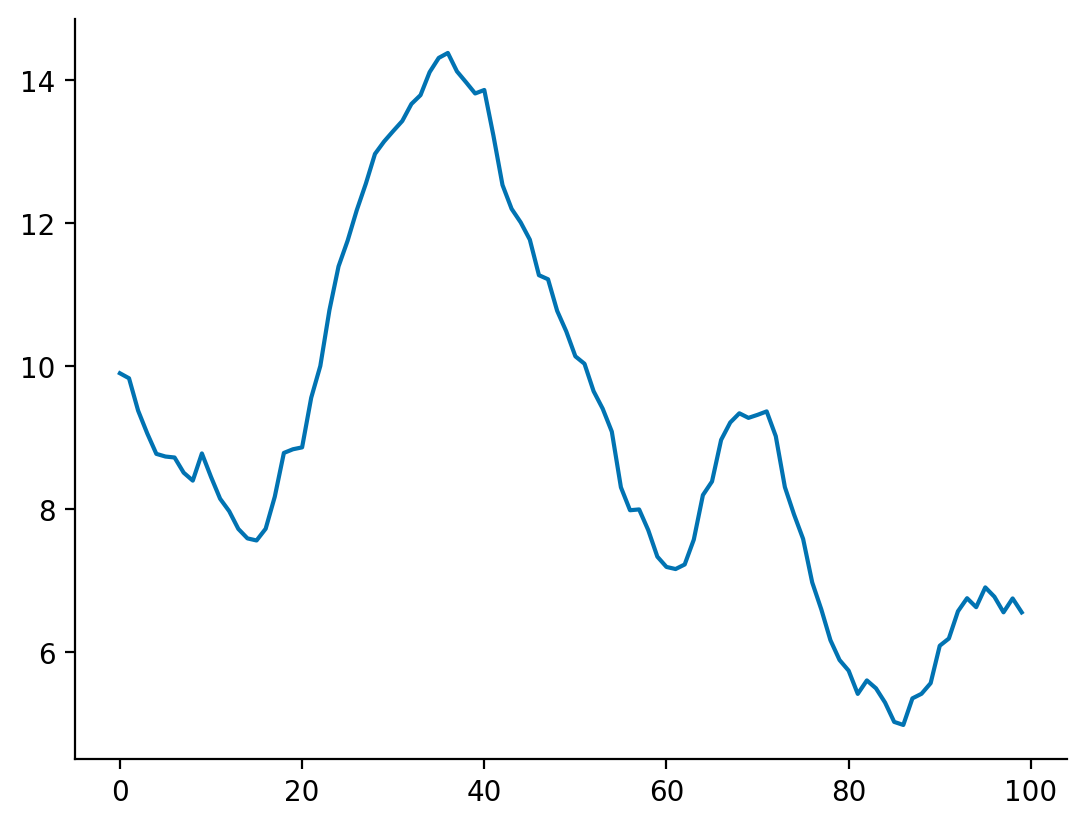

In [73]:
plt.plot(prices)

In [ ]:
@njit
def signal_step_ix(ix, ix_mid, force_signal, reversion_factor, n_bins_signal):
    """
    Index signal jump.
    The next index is the sum of the current index,
    a random-walk factor, and a (possibly) random reversion term
    """
    # Jump uniformly between -force_signal, force_signal
    choices = np.arange(-force_signal, force_signal + 1)
    ix_jump_signal = np.random.choice(choices)

    # Amount of indices to revert back to the mean
    ix_next = int(round(reversion_factor * (ix_mid - ix)))
    return ix_next


@njit
def price_step_ix(
    action, ix_price, ix_signal, force_price, price_impact, n_bins_price, n_bins_signal
):
    signal_shift = ix_signal - n_bins_signal // 2
    proba = sigmoid(price_impact * action)
    ix_shift = np.random.binomial(2 * force_price, proba) - force_price

    
    ix_next = ix_price + ix_shift #+ signal_shift
    ix_next = clip(ix_next, 0, n_bins_price - 1)
    return ix_next

Text(0.5, 0, 'ix move')

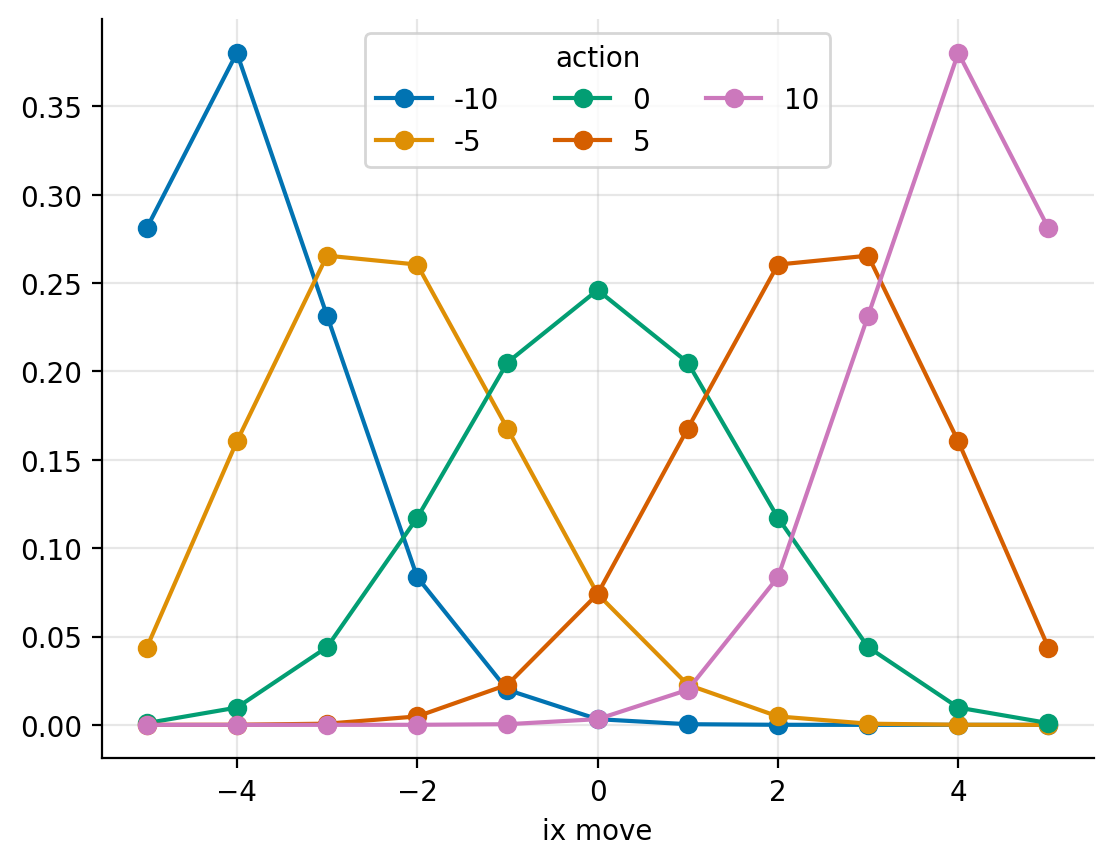

In [21]:
force_price = 5
price_impact = 0.2
prange = np.arange(0, 2 * force_price + 1)
ixrange = prange - force_price

for a in [-10, -5, 0, 5, 10]:
    dist = binom(2 * force_price, p=sigmoid(price_impact * a))
    probs = dist.pmf(prange)
    probs = probs / probs.sum()
    plt.plot(ixrange, probs, marker="o", label=a)
plt.grid(alpha=0.3)
plt.legend(title="action", ncol=3)
plt.xlabel("ix move")

---

## Old stuff

In [4]:
MAX_PRICE = 100 # price in [0, MAX_PRICE]
MAX_INVENTORY = 10 # max inventory per side
MAX_CASH = 50 # max cash per side
MAX_ACTION = 5 # max buy and sell
DISCOUNT = 0.9
MAX_SIGNAL = 1 # max value of signal per side

In [5]:
np.set_printoptions(linewidth=120, precision=4)

In [6]:
n_bins_signal = 50
n_bins_price = 30
bins_signal = np.linspace(-MAX_SIGNAL, MAX_SIGNAL, n_bins_signal)
if not 0 in bins_signal:
    bins_signal = np.sort(np.append(bins_signal, 0.0))

bins_price = np.linspace(0, MAX_PRICE, n_bins_price)

lattice_price = bins_price[:, None] + bins_signal[None, :]


# lattice_price[np.where((lattice_price < 0) | (lattice_price > MAX_PRICE))] = np.nan
lattice_price[np.where(lattice_price < 0)] = 0.0
lattice_price[np.where(lattice_price > MAX_PRICE)] = MAX_PRICE

Text(0.5, 1.0, 'price(t+1)')

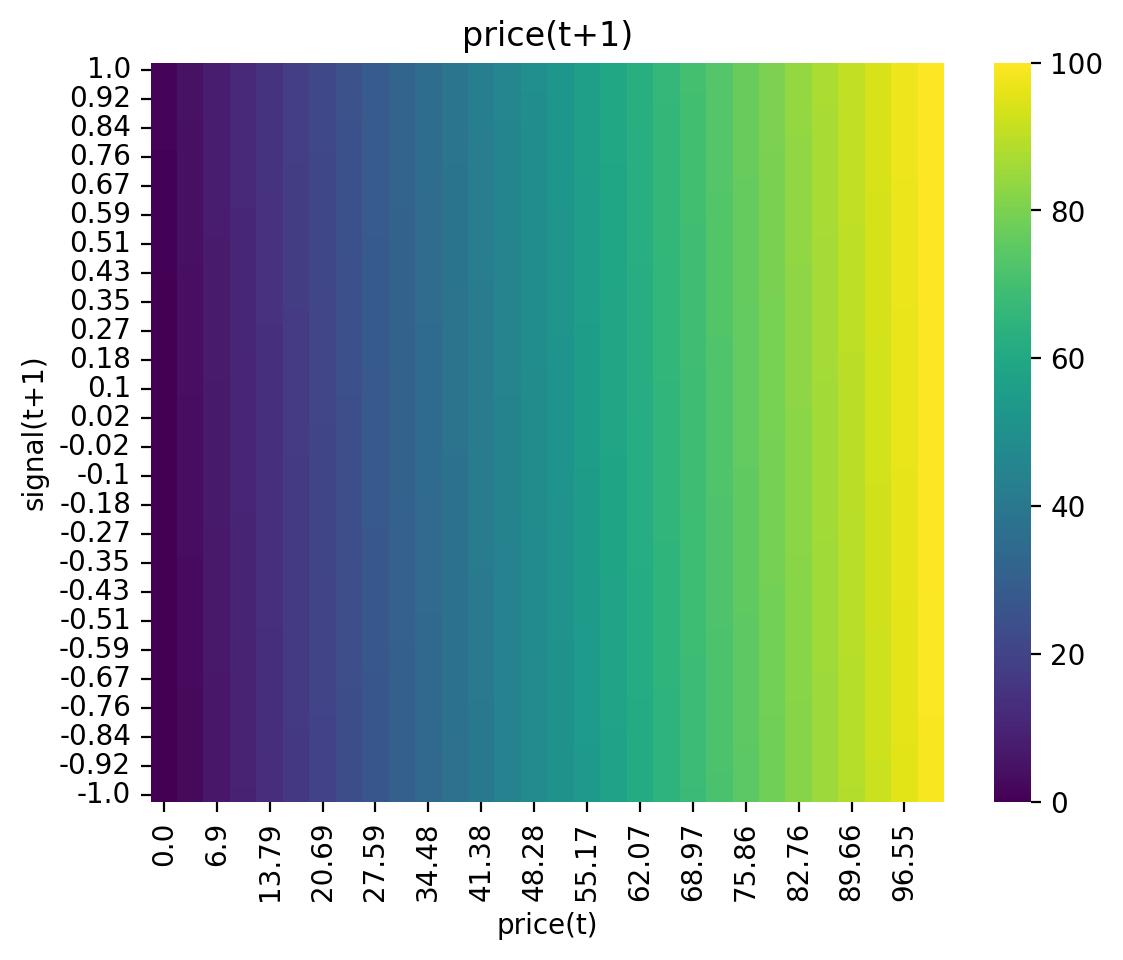

In [7]:
lattice_df = pd.DataFrame(
    lattice_price.T, columns=bins_price.round(2), index=bins_signal.round(2)
)
sns.heatmap(lattice_df, cmap="viridis")
plt.gca().invert_yaxis()
plt.xlabel("price(t)")
plt.ylabel("signal(t+1)")
plt.title("price(t+1)")

In [8]:
@njit
def set_seed(seed):
    np.random.seed(seed)

@njit
def sigmoid(z): return 1 / (1 + np.exp(-z))


@njit
def clip(a, a_min, a_max):
    return np.minimum(a_max, np.maximum(a, a_min))


@njit
def signal_step_ix(ix, ix_mid, force_signal, reversion_factor, n_bins_signal):
    """
    Index signal jump.
    The next index is the sum of the current index,
    a random-walk factor, and a (possibly) random reversion term
    """
    # Jump uniformly between -force_signal, force_signal
    choices = np.arange(-force_signal, force_signal + 1)
    ix_jump_signal = np.random.choice(choices)

    # Amount of indices to revert back to the mean
    ix_reversion = int(round(reversion_factor * (ix_mid - ix)))

    # Total amount moved
    ix_next = ix + ix_reversion + ix_jump_signal
    ix_next = clip(ix_next, 0, n_bins_signal - 1)
    return ix_next


@njit
def price_step_ix(action, ix_price, ix_signal, force_price, price_impact, n_bins_price, n_bins_signal):
    signal_shift = ix_signal - n_bins_signal // 2
    proba = sigmoid(price_impact * action)
    ix_shift = np.random.binomial(2 * force_price, proba) - force_price
    ix_next = ix_price + ix_shift #+ signal_shift
    ix_next = clip(ix_next, 0, n_bins_price - 1)
    return ix_next



def step_ix(
    ix_signal, ix_price, ix_mid,
    force_signal, reversion_factor, n_bins_signal,
    force_price, price_impact, n_bins_price,
):
    ix_next_signal = signal_step_ix(
        ix_signal, ix_mid, force_signal, reversion_factor, n_bins_signal
    )
    ix_next_price = price_step_ix(
        action, ix_price, n_bins_signal // 2 - 1, force_price, price_impact, n_bins_price, n_bins_signal
        # action, ix_price, ix_next_signal, force_price, price_impact, n_bins_price, n_bins_signal
    )

    return ix_next_signal, ix_next_price

Text(0.5, 0, 'ix move')

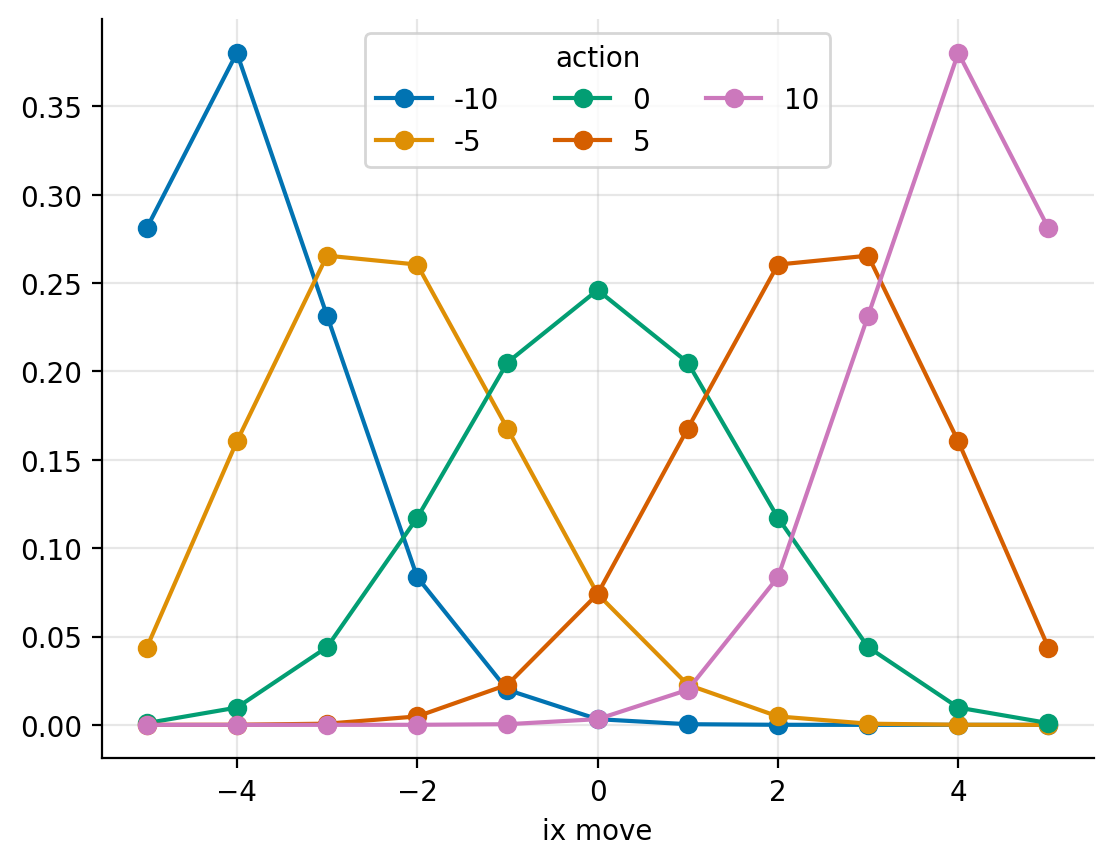

In [9]:
force_price = 5
price_impact = 0.2
prange = np.arange(0, 2 * force_price + 1)

ixrange = prange - force_price

for a in [-10, -5, 0, 5, 10]:
    dist = binom(2 * force_price, p=sigmoid(price_impact * a))
    probs = dist.pmf(prange)
    probs = probs / probs.sum()
    plt.plot(ixrange, probs, marker="o", label=a)
plt.grid(alpha=0.3)
plt.legend(title="action", ncol=3)
plt.xlabel("ix move")

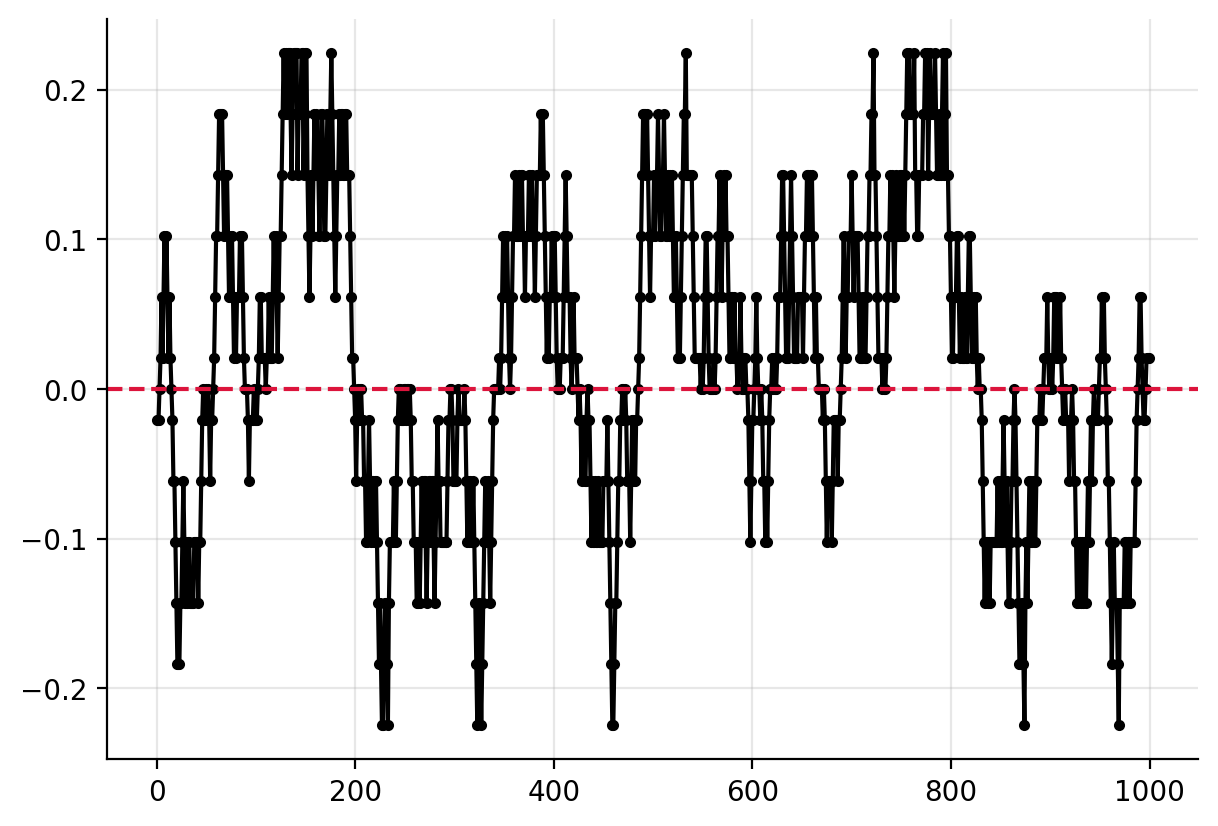

In [10]:
signal = bins_signal[25]
nsteps = 1000
signal_series = np.zeros(nsteps)

mid_ix = 25
ix_next = 25
set_seed(314)

force_signal = 1
reversion_factor = 0.1

for n in range(nsteps):
    ix_next = signal_step_ix(ix_next, mid_ix, force_signal, reversion_factor, n_bins_signal)
    signal = bins_signal[ix_next]
    signal_series[n] = signal

fig, ax = plt.subplots(figsize=(6.4 * 1.1, 4.8))
plt.plot(signal_series, c="black", marker="o", markersize=3)
plt.axhline(y=0, c="crimson", linestyle="--")
plt.grid(alpha=0.3)

In [13]:
lattice_price[20, 20]

68.78184377199155

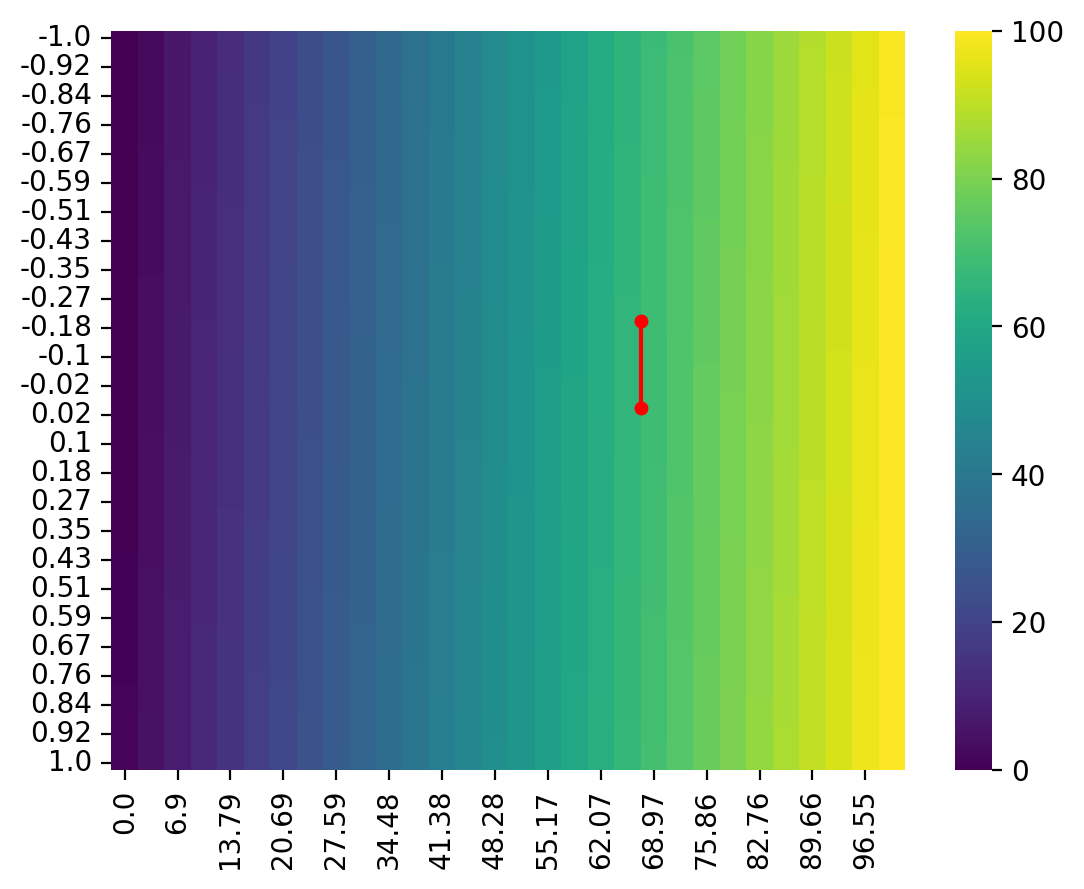

In [42]:
sns.heatmap(lattice_df, cmap="viridis")
x, y = [20, 20], [20, 26]
plt.plot(x, y, c="red", marker="o", markersize=4)

In [44]:
lattice_df.iloc[[26]].iloc[:, [20]]

,68.97
0.02,68.985925


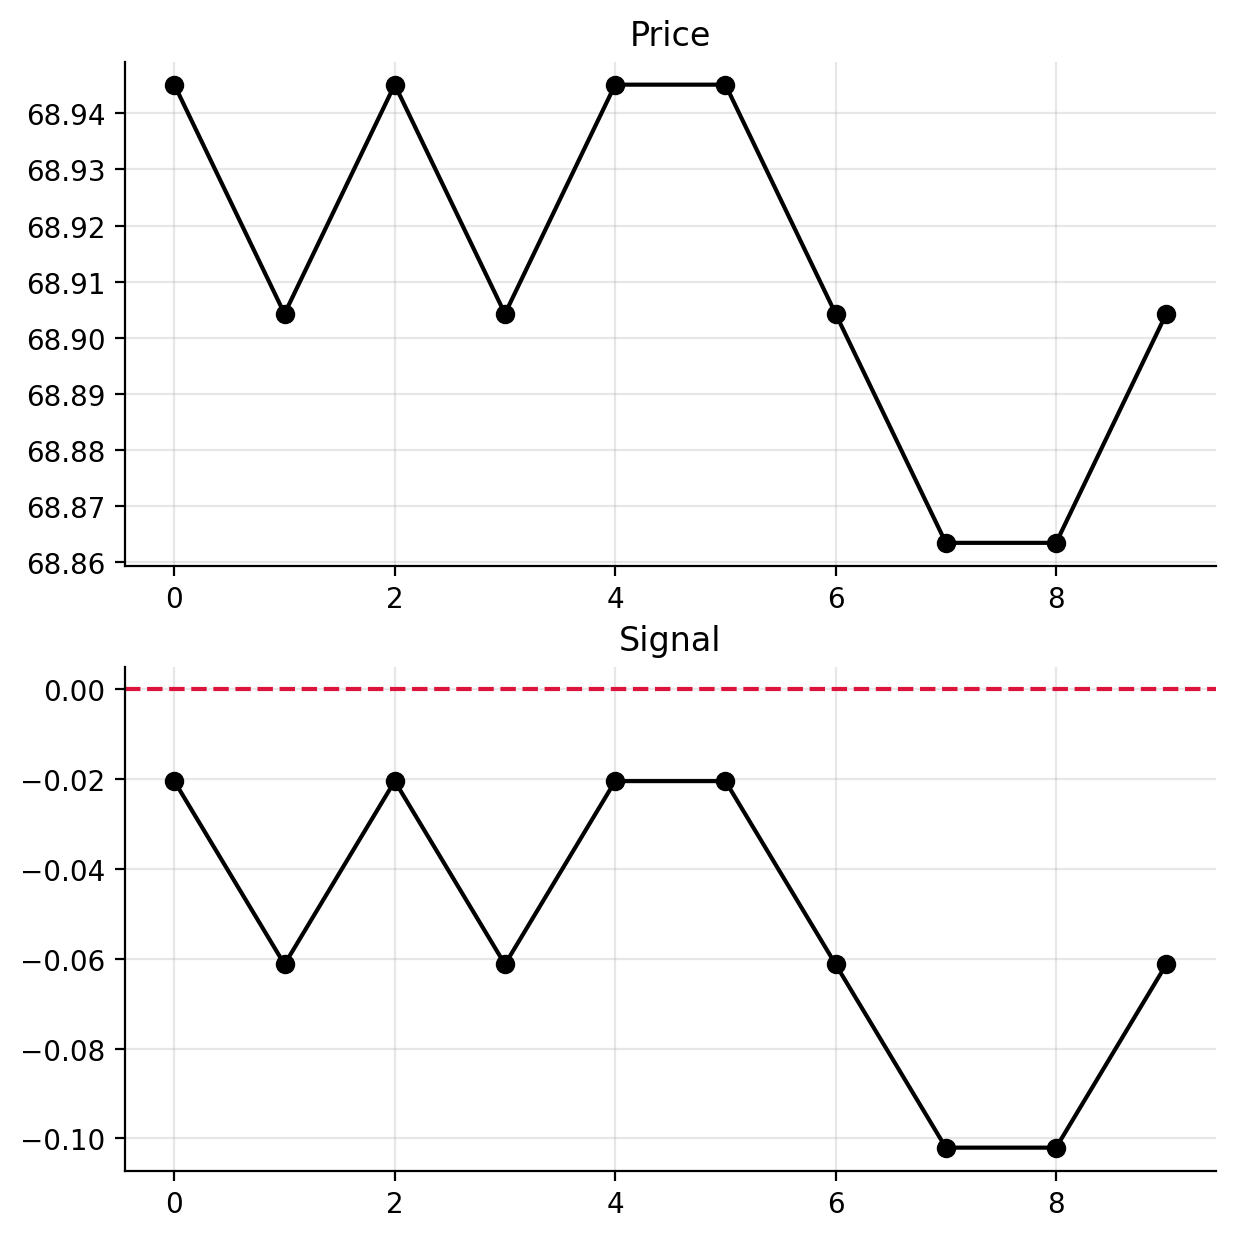

In [12]:
force_signal = 1 # equivalent to the standard deviation in the signal process
reversion_factor = 0.1

force_price = 0 # the equivalent to the standard deviation in the price process
price_impact = 0.1 # price impact on the action taken

signal = bins_signal[25]
nsteps = 10# 1000
signal_series = np.zeros(nsteps)
price_series = np.zeros(nsteps)

mid_ix = 25

ix_signal = 25
ix_price = 20
action = 0

ixs_signal = np.zeros(nsteps)
ixs_price = np.zeros(nsteps)

set_seed(3142)
# set_seed(2)
for n in range(nsteps):
    ix_signal, ix_price = step_ix(
        ix_signal, ix_price, mid_ix,
        force_signal, reversion_factor, n_bins_signal,
        force_price, price_impact, n_bins_price
    )
    signal = bins_signal[ix_signal]
    shift = ix_signal - n_bins_signal // 2
    price = lattice_price[ix_price, ix_signal]

    ixs_signal[n] = ix_signal
    ixs_price[n] = ix_price
    
    signal_series[n] = signal
    price_series[n] = price

fig, axs = plt.subplots(2, 1, figsize=(6.4 * 1.1, 4.8 * 1.5))
axs[0].plot(price_series, c="black", marker="o")
axs[1].plot(signal_series, c="black", marker="o")
axs[0].grid(alpha=0.3)
axs[1].grid(alpha=0.3)
axs[0].set_title("Price")
axs[1].set_title("Signal")
axs[1].axhline(y=0, c="crimson", linestyle="--")

## Towards $n$-step TD

# Value iteration
The Bellman equation for the optimal value function satisfies
$$
    v_*(s) = \max_a\sum_{s',r}
    \underbrace{
        p(s',r | s, a)
    }_\text{MDP}
    [r + \gamma v_*(s')].
$$

If the Markov decision process (MDP) is known, i.e., $p(s', r \vert s, a)$,
then the optimal value function can be found by value iteration.

In the the next block, we define the components that describe the MDP for the price impact problem.
The state in this problem are:
(i) the observed price,
(ii) the latent signal, and
(iii) the inventory.

## Evaluating the MDP

In [161]:
from numba import vectorize

In [162]:
LOOKUP_TABLE = np.array([
    1, 1, 2, 6, 24, 120, 720, 5040, 40320,
    362880, 3628800, 39916800, 479001600,
    6227020800, 87178291200, 1307674368000,
    20922789888000, 355687428096000, 6402373705728000,
    121645100408832000, 2432902008176640000], dtype="int64")



# @vectorize([float64(int64)])
@njit
def factorial(n):
    """
    reference:
    https://stackoverflow.com/a/44391133/11278455
    """
    if n > 20:
        raise ValueError
    return LOOKUP_TABLE[n]


@njit
def combinations(n, k):
    num = factorial(n)
    den = factorial(k) * factorial(n - k)
    return num / den


@vectorize(identity=1)
def pmf_uniform(x, x_low, x_high):
    pr = 1 / (x_high - x_low + 1)
    return pr * (x <= x_high) * (x >= x_low)


@vectorize(identity=1)
def pmf_binom(k, n, p):
    """
    Probability mass function (pmf) at x
    for a binomial ditribution with
    n trials and k successes

    TODO: make numerically stable
    """
    if k > n:
        return 0.0
    
    Z = combinations(n, k)
    pr =  Z * np.power(p, k) * np.power(1 - p, n - k)
    return pr

In [163]:
def pr_transition_price(
    pix_curr, pix_prev, pix_fluctuation, action, price_impact, price_force
):
    """
    Probability of transitioning to a new price
    """
    pix_curr_hat = pix_prev + pix_fluctation - price_force
    # TODO: add clipping
    p = sigmoid(price_impact * action)
    pr_fluctuation = pmf_binom(pix_fluctutaion, 2 * price_force, p)
    pr_price_transition = (pix_curr == pix_curr_hat)
    return pr_fluctuation * pr_price_transition


def pr_transition_signal(
    six_curr, six_prev, six_mid, six_fluctuation, mean_reversion_force, signal_force
):
    """
    Probability of transitioning to a new signal

    Parameters
    ----------
    six_curr: int
        signal index at the current timestep
    six_prev: int
        signal index at the previous timestep
    six_mid: int
        signal reference index
    six_fluctuation: int
        random signal index fluctutation
    mean_reversion_force: float
        force of reversion to the mean
    signal_force: int
        maximum number of indices (up and down)
    """
    six_curr_hat = six_prev + np.round(mean_reversion_force * (six_prev - six_mid)) + fluctuation
    pr_fluctuation = 1 / (2 * force_signal)
    pr_signal_transition = (six_curr == six_curr_hat)
    return pr_fluctuation * pr_signal_transition

In [164]:
@vectorize(identity=0)
def pr_transition_price_fluctuation(
    pix_fluctuation, action, price_impact, price_force
):
    """
    Probability pix fluctuation
    """
    p = sigmoid(price_impact * action)
    pr_fluctuation = pmf_binom(pix_fluctuation, 2 * price_force, p)
    return pr_fluctuation

@vectorize(identity=0)
def pr_transition_signal_fluctuation(
    six_fluctuation, signal_force
):
    return 1 / (2 * signal_force + 1)

In [165]:
@njit
def step_six(
    six_prev, six_fluctuation, six_mid, mean_reversion_force, n_bins_signal
):
    """
    Obtain next signal index (six)
    """
    six_curr = six_prev + round(mean_reversion_force * (six_prev - six_mid)) + six_fluctuation
    six_curr = clip(six_curr, 0, n_bins_signal - 1)
    return six_curr


@njit
def step_pix(
    pix_prev, pix_fluctuation, n_bins_price
):
    pix_curr = pix_prev + pix_fluctuation
    pix_curr = clip(pix_curr, 0, n_bins_price - 1)
    return pix_curr


@njit
def step_inventory(inventory_prev, action):
    return clip(inventory_prev + action, -MAX_INVENTORY, MAX_INVENTORY)

In [166]:
@njit
def get_reward(
    action,
    six_fluctuation, six_prev, six_mid, mean_reversion_force,
    pix_fluctuation, pix_prev, price_impact,
    inventory_prev, grid_signal, grid_price,
    inventory_aversion, temporary_price_impact
):
    # Compute signal and price updates
    six_curr = step_six(six_prev, six_fluctuation, six_mid, mean_reversion_force, n_bins_signal)
    pix_curr = step_pix(pix_prev, pix_fluctuation, n_bins_price)

    inventory_curr = step_inventory(inventory_prev, action)
    inventory_ix_next = inventory_curr + MAX_INVENTORY

    price_prev = grid_price[pix_prev, six_prev]
    price_curr = grid_price[pix_curr, six_curr]

    reward = (
          inventory_prev * (price_curr - price_prev)
        - action ** 2 * (inventory_aversion + temporary_price_impact)
        - 2 * inventory_aversion * inventory_prev * action
        + action * (price_curr - price_prev)
    )

    six_curr = int(six_curr)
    pix_curr = int(pix_curr)
    inventory_ix_next = int(inventory_ix_next)

    return reward, (six_curr,  pix_curr, inventory_ix_next)

In [171]:
action = -5
six_fluctuation = 0
six_prev = 0
six_mid = 25
mean_reversion_force = 0.1
signal_force = 2

pix_fluctuation = 2
pix_prev = 10
price_impact = 0.1
price_force = 2

inventory_prev = 10
inventory_aversion = 1
temporary_price_impact = 1

In [172]:
get_reward(
    action,
    six_fluctuation, six_prev, six_mid, mean_reversion_force,
    pix_fluctuation, pix_prev, price_impact,
    inventory_prev,
    bins_signal, lattice_price,
    inventory_aversion, temporary_price_impact
)

(60.344827586206904, (0, 12, 15))

In [173]:
@njit
def value_function(
    action, six_prev, pix_prev, inventory_ix, six_mid, mean_reversion_force, price_impact,
    inventory_aversion, temporary_price_impact,
    bins_signal, lattice_price, signal_force, price_force, V, discount
):
    value = 0.0
    inventory_prev = inventory_ix - MAX_INVENTORY
    for six_fluctuation in np.arange(2 * signal_force + 1):
        for pix_fluctuation in np.arange(2 * price_force + 1):
            r, (six_next, pix_next, iix_next) = get_reward(
                action,
                six_fluctuation, six_prev, six_mid, mean_reversion_force,
                pix_fluctuation, pix_prev, price_impact,
                inventory_prev,
                bins_signal, lattice_price,
                inventory_aversion, temporary_price_impact
            )
            pr_price = pr_transition_price_fluctuation(pix_fluctuation, action, price_impact, price_force)
            pr_signal = pr_transition_signal_fluctuation(six_fluctuation, signal_force)
            value += pr_signal * pr_price * (r + discount * V[six_next, pix_next, iix_next])
    return value

In [174]:
@njit
def policy_eval_single(
    six_mid, mean_reversion_force, price_impact,
    inventory_aversion, temporary_price_impact, bins_signal,
    lattice_price, signal_force, price_force, V, policy, discount
):
    V = V.copy()
    max_err = -1.0
    for six_prev in np.arange(n_bins_signal):
        for pix_prev in np.arange(n_bins_price):
            for iix_prev in np.arange(2 * MAX_INVENTORY + 1):
                action = policy[six_prev, pix_prev, iix_prev]
                v = value_function(
                    action, six_prev, pix_prev, iix_prev, six_mid, mean_reversion_force, price_impact,
                    inventory_aversion, temporary_price_impact,
                    bins_signal, lattice_price, signal_force, price_force, V, discount
                )
                # Compute error
                vprev = V[six_prev, pix_prev, iix_prev]
                vmax_err = np.abs(v - vprev)
                max_err = max_err if vmax_err < max_err else vmax_err
                
                # Update
                V[six_prev, pix_prev, iix_prev] = v
    return V, max_err

@njit
def policy_eval(
    six_mid, mean_reversion_force, price_impact,
    inventory_aversion, temporary_price_impact, bins_signal,
    lattice_price, signal_force, price_force, V, policy, discount,
    tol=1e-3, n_its_max=100
):
    errs = []
    for n in range(n_its_max):
        V, err = policy_eval_single(
            six_mid, mean_reversion_force, price_impact,
            inventory_aversion, temporary_price_impact, bins_signal,
            lattice_price, signal_force, price_force, V, policy, discount
        )
        errs.append(err)
        if err <= tol:
            break
    return V, np.array(errs)

In [175]:
policy = np.zeros((
    n_bins_signal,
    n_bins_price,
    2 * MAX_INVENTORY + 1
))

V = np.zeros((
    n_bins_signal,
    n_bins_price,
    2 * MAX_INVENTORY + 1,
))

V.shape

(50, 30, 21)

In [176]:
%%time
discount = 0.9
V, errs = policy_eval(
    six_mid, mean_reversion_force, price_impact,
    inventory_aversion, temporary_price_impact, bins_signal,
    lattice_price, signal_force, price_force, V, policy, discount,
)

CPU times: user 2.76 s, sys: 83.7 ms, total: 2.84 s
Wall time: 2.84 s


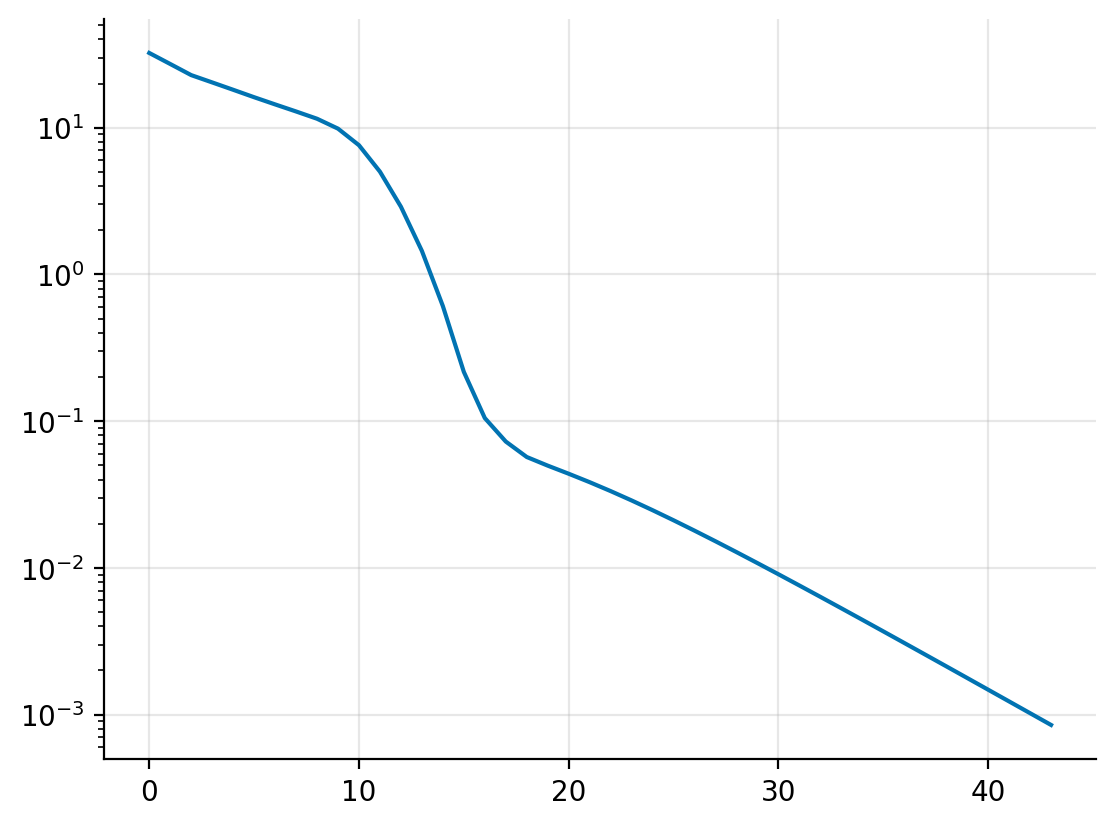

In [177]:
plt.plot(errs)
plt.yscale("log")
plt.grid(alpha=0.3)

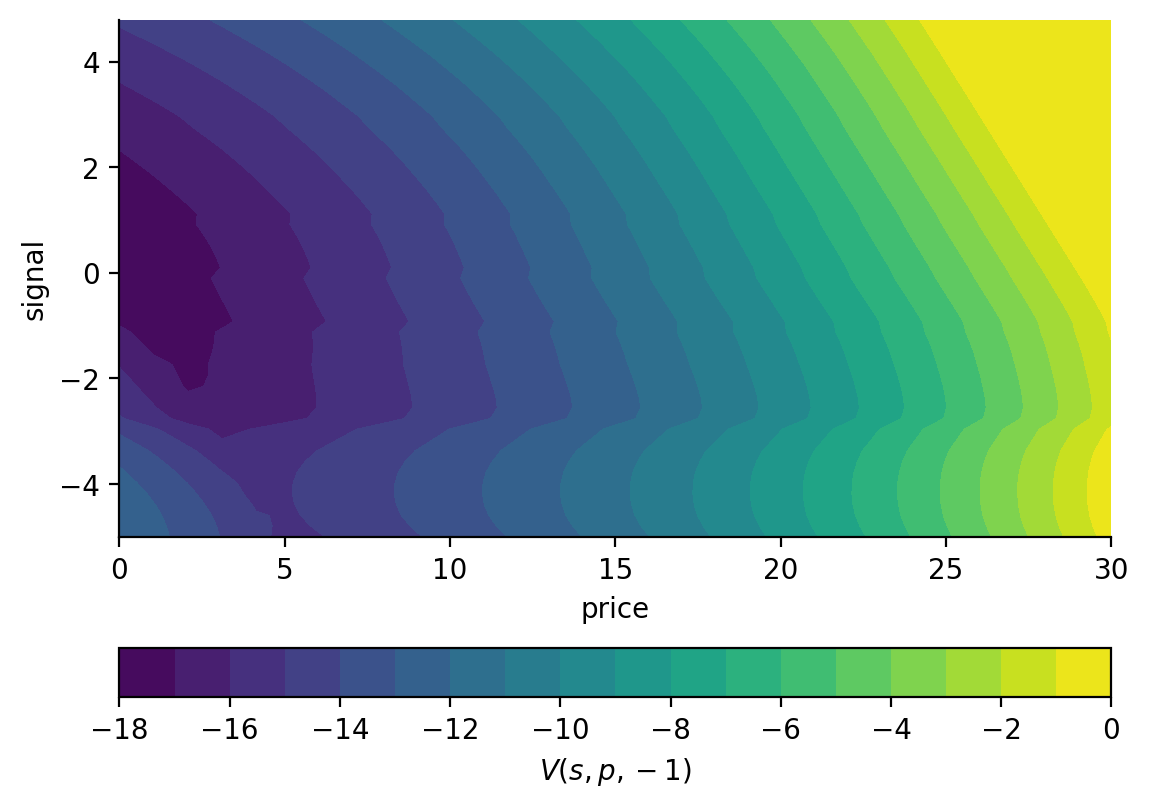

In [178]:
plt.contourf(bins_price, bins_signal[:-1], V[..., MAX_INVENTORY -1], levels=20)
plt.xlabel("price")
plt.ylabel("signal")
plt.colorbar(orientation="horizontal", label="$V(s, p, -1)$")

In [180]:
@njit
def policy_improvement_single(
    six_mid, mean_reversion_force, price_impact,
    inventory_aversion, temporary_price_impact,
    bins_signal, lattice_price, signal_force, price_force, V, policy, discount
):
    policy = policy.copy()
    actions_array = np.arange(-MAX_ACTION, MAX_ACTION + 1)
    for six_prev in np.arange(n_bins_signal):
        for pix_prev in np.arange(n_bins_price):
            for iix_prev in np.arange(2 * MAX_INVENTORY + 1):
                amax = -1
                vmax = -np.inf
                for action in actions_array:
                    v = value_function(
                        action, six_prev, pix_prev, iix_prev, six_mid, mean_reversion_force, price_impact,
                        inventory_aversion, temporary_price_impact,
                        bins_signal, lattice_price, signal_force, price_force, V, discount
                    )
                    if v > vmax:
                        vmax = v
                        amax = action

                policy[six_prev, pix_prev, iix_prev] = amax
    return policy


@njit
def policy_improvement(
    six_mid, mean_reversion_force, price_impact, inventory_aversion, temporary_price_impact,
    bins_signal, lattice_price, signal_force, price_force, V, policy, discount,
    n_its_max = 10
):
    for n in range(n_its_max):
        policy_new = policy_improvement_single(
            six_mid, mean_reversion_force, price_impact,
            inventory_aversion, temporary_price_impact,
            bins_signal, lattice_price, signal_force, price_force, V, policy, discount
        )
        if (policy_new == policy).all():
            policy = policy_new
            break
        policy = policy_new
    return policy

## Policy iteration

In [181]:
inventory_aversion = 0.0

policy = np.zeros((
    n_bins_signal,
    n_bins_price,
    2 * MAX_INVENTORY + 1
))

V = np.zeros((
    n_bins_signal,
    n_bins_price,
    2 * MAX_INVENTORY + 1,
))

V.shape

(50, 30, 21)

## Policy iteration

In [182]:
inventory_prev = 2 * MAX_INVENTORY
action = -5
pix_prev = 20
six_prev = 0
v = value_function(
    action, six_prev, pix_prev, inventory_prev, six_mid, mean_reversion_force, price_impact,
    inventory_aversion, temporary_price_impact,
    bins_signal, lattice_price, signal_force, price_force, V, discount
)
v

-16.576568851044698

In [183]:
%%time
V, errs = policy_eval(
    six_mid, mean_reversion_force, price_impact,
    inventory_aversion, temporary_price_impact, bins_signal,
    lattice_price, signal_force, price_force, V, policy, discount,
    n_its_max=100
)

CPU times: user 2.48 s, sys: 59.6 ms, total: 2.54 s
Wall time: 2.53 s


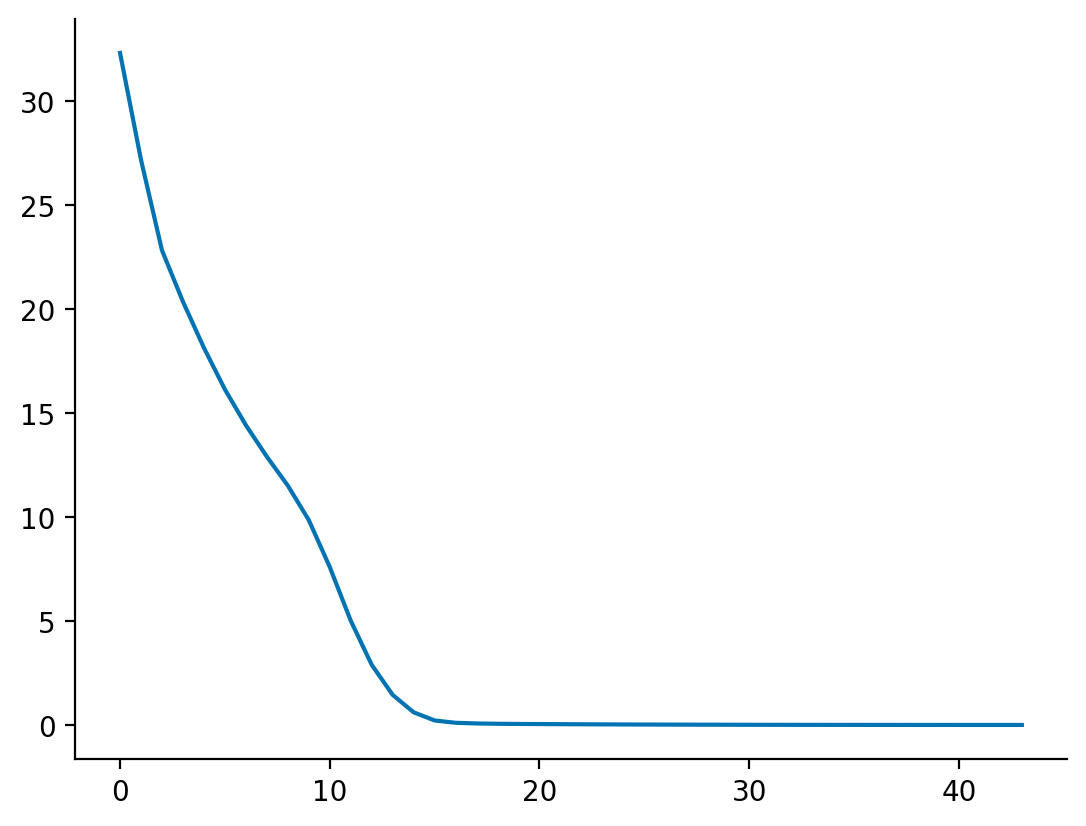

In [184]:
plt.plot(errs)

In [185]:
%%time
policy = policy_improvement(
    six_mid, mean_reversion_force, price_impact,
    inventory_aversion, temporary_price_impact, bins_signal,
    lattice_price, signal_force, price_force, V, policy, discount,
    n_its_max=10
)

CPU times: user 1.38 s, sys: 3.3 ms, total: 1.38 s
Wall time: 1.38 s


In [188]:
policy.min()

0.0

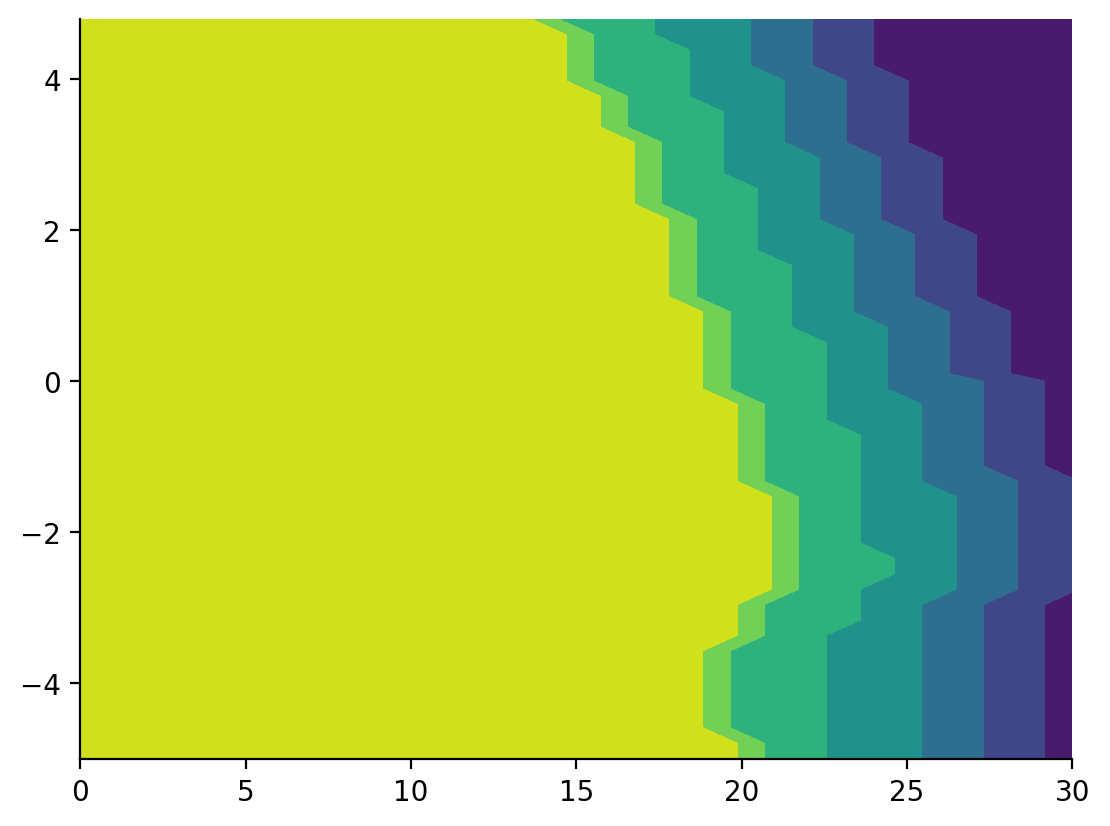

In [187]:
plt.contourf(bins_price, bins_signal[:-1], policy[..., MAX_INVENTORY - 3])